# Non-machine learning approach

Use product, client, agency, and sales channel ID, along with route information to predict demand based on mean averages for those values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, datetime

from multiprocessing import Pool, cpu_count

%matplotlib inline

dataurl = '/home/dbricare/Documents/Python/datasets/bimbo/'

/usr/local/lib/python3.5/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
def inspectdata(testortrain, cols=None, rows=None):
    dataparams = {'sep':',', 'compression':'zip', 'usecols':cols, 'nrows':rows}
    df = pd.read_csv(dataurl+testortrain+'.csv.zip', **dataparams)
    print('Number of records:{0:,}'.format(len(df)))
    dictcols = dict(zip(list(df.columns),[df[col].dtype for col in df.columns]))
    print(dictcols)
    return df

# Load and examine training data

In [3]:
usecols = ['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 
                                    'Demanda_uni_equil']

dftrain = None  # clear memory
dftrain = inspectdata('train', cols=usecols)
dftrain.head()

Number of records:74,180,464
{'Demanda_uni_equil': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Agencia_ID': dtype('int64'), 'Producto_ID': dtype('int64'), 'Canal_ID': dtype('int64')}


Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID  Demanda_uni_equil
0        1110         7      3301       15766         1212                  3
1        1110         7      3301       15766         1216                  4
2        1110         7      3301       15766         1238                  4
3        1110         7      3301       15766         1240                  4
4        1110         7      3301       15766         1242                  3

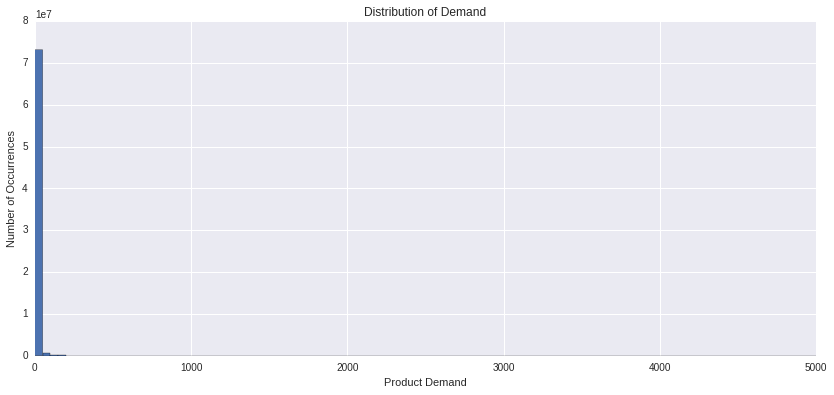

In [12]:
# distribution of values

_ = plt.figure(figsize=(14,6))
_ = plt.title('Distribution of Demand')
_ = plt.xlabel('Product Demand')
_ = plt.ylabel('Number of Occurrences')
# _ = plt.xlim(0,5000)

_ = dftrain['Demanda_uni_equil'].hist(bins=100)

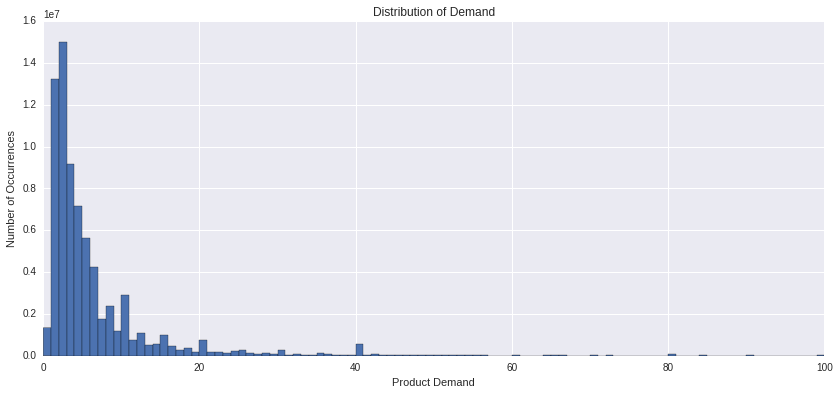

In [13]:
# finer grain distribution

_ = plt.figure(figsize=(14,6))
_ = plt.title('Distribution of Demand')
_ = plt.xlabel('Product Demand')
_ = plt.ylabel('Number of Occurrences')
_ = plt.xlim(0,100)

_ = dftrain['Demanda_uni_equil'][dftrain['Demanda_uni_equil']<=100].hist(bins=100)

In [22]:
# global statistics for demand

stats = dftrain['Demanda_uni_equil'].describe()
globalmean = stats.loc['mean']
stats

count    7.418046e+07
mean     7.224564e+00
std      2.177119e+01
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      5.000000e+03
Name: Demanda_uni_equil, dtype: float64

In [7]:
# most common value

print('Most common weekly demand value:', dftrain['Demanda_uni_equil'].mode().values[0])

Most common weekly demand value: 2


## Calculate 5-key group mean averages of `Demanda_uni_equil`

In [14]:
dffive = dftrain.groupby(['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID']).Demanda_uni_equil.mean()
dffive = dffive.reset_index(drop=False)
print(dffive.shape)
dffive.head()

(26396648, 6)


Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID  Demanda_uni_equil
0        1110         7      3301       15766          325           1.000000
1        1110         7      3301       15766          328           1.000000
2        1110         7      3301       15766         1212           3.400000
3        1110         7      3301       15766         1216           2.833333
4        1110         7      3301       15766         1220           2.000000

# Load test data

In [5]:
# testiter = pd.read_csv(dataurl+'test.csv.zip', sep=',', compression='zip', chunksize=1000000, usecols=rawcols[:-1])

testcols = usecols[:-1].copy()
testcols.insert(0, 'id')

dftest = inspectdata('test', cols=testcols)
dftest.head()

(6999251, 6)
{'Ruta_SAK': dtype('int64'), 'Canal_ID': dtype('int64'), 'id': dtype('int64'), 'Producto_ID': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Agencia_ID': dtype('int64')}


id  Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID
0   0        4037         1      2209     4639078        35305
1   1        2237         1      1226     4705135         1238
2   2        2045         1      2831     4549769        32940
3   3        1227         1      4448     4717855        43066
4   4        1219         1      1130      966351         1277

## Join test data with mean averages for 5-key group

Fill in `NaN` values with the most commonly occurring demand value.

In [15]:
dfjoin = pd.merge(dftest, dffive, how='left', on=usecols[:-1])

dfjoin.head()

id  Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID  \
0   0        4037         1      2209     4639078        35305   
1   1        2237         1      1226     4705135         1238   
2   2        2045         1      2831     4549769        32940   
3   3        1227         1      4448     4717855        43066   
4   4        1219         1      1130      966351         1277   

   Demanda_uni_equil  
0                4.0  
1                NaN  
2                2.0  
3                NaN  
4                NaN

In [16]:
# save the non-null Demand entries to disk for quick loading in the future

dfjoin[['id', 'Demanda_uni_equil']][dfjoin['Demanda_uni_equil'].notnull()].to_csv(
    dataurl+'5keyresults.csv', sep=',', index=False)

In [17]:
# also save the full dataframe null values to disk

dfjoin[dfjoin['Demanda_uni_equil'].isnull()].to_csv(dataurl+'5keynull.csv', sep=',', index=False)

In [26]:
# check number of NaN values and fill in with most common demand value (demand=2)

nas = dfjoin['Demanda_uni_equil'].isnull().sum()
print('Number of new products is {0:} out of {1:}'.format(nas, len(dfjoin)))
dfjoin['Demanda_uni_equil'].fillna(2, inplace=True)

dfjoin.head()

Number of new products is 1446543 out of 6999251


id  Agencia_ID  Canal_ID  Ruta_SAK  Cliente_ID  Producto_ID  \
0   0        4037         1      2209     4639078        35305   
1   1        2237         1      1226     4705135         1238   
2   2        2045         1      2831     4549769        32940   
3   3        1227         1      4448     4717855        43066   
4   4        1219         1      1130      966351         1277   

   Demanda_uni_equil  
0                4.0  
1                2.0  
2                2.0  
3                2.0  
4                2.0

In [28]:
def mloutput(df, dataurl=dataurl):
    # save prediction
    import datetime
    nowtime = datetime.datetime.now()
    nowstr = nowtime.strftime('%Y%m%d_%H%M')
    df.to_csv(dataurl+'mloutput'+nowstr+'.csv', sep=',', index=False)
    return

In [29]:
mloutput(dfjoin[['id','Demanda_uni_equil']])

### Leaderboard result: 0.53532 RMSLE

___

## Repeat but fill in missing weekly values with zero

The weekly range for the training data is 3-9. This approach will modify the mean average function to count the number of existing entries and supplement them with zero.

In [7]:
# how many unique entries are there for each of the 5 keys used above?
# this value describes the average number of weekly entries for each identifier (5 keys)

print(len(dftrain.drop_duplicates(usecols[:-1])),'/',len(dftrain))

26396648 / 74180464


In [6]:
from collections import OrderedDict

def meanzero(tup):
    '''takes in tuple of (name,df) from mp.pool.
    returns scalar value.'''
    # augment demand list with zeros for missing weeks
    demand = np.sum(tup[1]['Demanda_uni_equil'])/7
    return demand
    
    # create dictionary to construct dataframe (faster than using df.set_value())
#     cols = tup[1].columns.tolist()
#     d = OrderedDict(zip(cols,tup[0]))
#     d['Demanda_uni_equil'] = np.mean(demand)
#     return pd.DataFrame(d, index=[0])
#     tup[1].set_value(tup[1].index[0], 'Demanda_uni_equil', np.mean(demand))
#     return tup[1].iloc[0].to_frame().transpose()

In [15]:
# dftrain['Demanda_uni_equil'] = dftrain['Demanda_uni_equil'].astype(float)
%timeit -r1 -n1 meanzero(list(dftrain.head(1000).groupby(usecols[:-1]))[0])
# a.set_value(0, 'Demanda_uni_equil', 1.1)
# a

1 loop, best of 1: 79.7 ms per loop


In [7]:
def applyParallel(dfGrouped, func):
    '''use multiprocessing to apply function to grouped dataframe.
    sends tuple of name and group to func.'''
    with Pool(cpu_count()-1) as p:
        # ret_list = p.map(func, [group for name, group in dfGrouped])
        ret_list = p.map(func, list(dfGrouped))
    # df = pd.concat(ret_list, ignore_index=True)
    return pd.Series(ret_list)

def chunkApply(df, col, groupcols, func):
    '''break large dataframe into chunks based on percentiles for in-memory processing.
    appends each processed chunk to a csv file.
    requires `col` for determining chunking and `groupcols` for keys to use in grouping.
    requires `dataurl` be set globally'''
    percents = np.arange(0,100,4)  # 20 different chunks
    vals = [df[col].max()+1]
    for p in percents:
        vals.append(int(np.percentile(df[col],p)))
    vals.sort()
    # vals = [df[col].min(), df[col].min()+1]
    print('Chunk indices:', vals) 
    
    for i in range(1,len(vals)):   
        # select portion
        dfpart = df[(df[col]>=vals[i-1]) & (df[col]<vals[i])]
        print('Part {:0} of {:1}'.format(i,len(vals)-1))
        print('Row count:', '{:,}'.format(len(dfpart)))
        # group dataframe by product and client ID
        dfGrouped = dfpart.groupby(groupcols)

        chunk = applyParallel(dfGrouped, func)
        dfpart = None
        dfGrouped = None
        # overwrite existing file on first pass, otherwise append to file
        if i==1:
            writemode = 'w'
            writehead = True
        else:
            writemode = 'a'
            writehead = False

        chunk.to_csv(dataurl+'chunks.csv', sep=',', index=False, header=writehead, mode=writemode)
        chunk = None

    return # chunk

In [8]:
# be sure to convert demand from integer to float before analyzing
# dftrain['Demanda_uni_equil'] = dftrain['Demanda_uni_equil'].astype(float)

chunkApply(dftrain, 'Producto_ID', usecols[:-1], meanzero)

Chunk indices: [41, 1109, 1146, 1182, 1220, 1238, 1240, 1250, 1284, 2025, 2425, 4259, 30214, 30572, 31484, 32861, 34868, 35571, 36747, 40886, 43039, 43069, 43199, 43274, 44829, 49998]
Part 1 of 25
Row count: 2,363,210
Part 2 of 25
Row count: 3,239,099
Part 3 of 25
Row count: 3,215,745
Part 4 of 25
Row count: 2,832,082
Part 5 of 25
Row count: 3,078,924
Part 6 of 25
Row count: 1,191,873
Part 7 of 25
Row count: 4,190,519
Part 8 of 25
Row count: 3,332,033
Part 9 of 25
Row count: 3,244,550
Part 10 of 25
Row count: 2,067,265
Part 11 of 25
Row count: 3,655,162
Part 12 of 25
Row count: 3,180,160
Part 13 of 25
Row count: 2,525,907
Part 14 of 25
Row count: 3,424,102
Part 15 of 25
Row count: 2,919,991
Part 16 of 25
Row count: 2,920,758
Part 17 of 25
Row count: 2,901,863
Part 18 of 25
Row count: 3,100,501
Part 19 of 25
Row count: 2,971,914
Part 20 of 25
Row count: 2,927,119
Part 21 of 25
Row count: 2,775,631
Part 22 of 25
Row count: 3,175,753
Part 23 of 25
Row count: 2,848,154
Part 24 of 25
Row co

## Repeat with improved NA filling

There are a lot of missing demand values in the test set, about 1 in 7 don't appear in the training data. It would be useful to find a better estimate for these new products. Perhaps by dropping the product ID from the grouping.

In [12]:
# how many test product IDs are missing from the training set? how much of the dataset is this?

sermiss = pd.Series(np.intersect1d(dftest['Producto_ID'].values, dftrain['Producto_ID'].values))
misscount = len(dftest['Producto_ID'].unique()) - len(sermiss.unique())
valcounts = dftest['Producto_ID'].value_counts(sort=False).to_dict()
total = len(dftest) - sum([valcounts[prod] for prod in sermiss.unique()])

print('{0:,} new product IDs out of {1:,} total product IDs'.format(misscount, len(dftest['Producto_ID'].unique())))
print('{0:,} new product occurrences out of {1:,} total records'.format(total,len(dftest)))

34 new product IDs out of 1,522 total product IDs
25,640 new product occurrences out of 6,999,251 total records


In [1]:
# any other new IDs?

def missing(col):
    sermiss = pd.Series(np.intersect1d(dftest[col].values, dftrain[col].values, assume_unique=False))
    misscount = len(dftest[col].unique()) - len(sermiss.unique())
    valcounts = dftest[col].value_counts(sort=False).to_dict()
    total = len(dftest) - sum([valcounts[prod] for prod in sermiss.unique()])
    print('{0:,} new {2} out of {1:,} total'.format(misscount, len(dftest[col].unique()), col))
    print('{0:,} new record occurrences out of {1:,} total records'.format(total,len(dftest)))
    return

In [10]:
features = testcols[1:]
for feature in features:
    missing(feature)
    print('')

0 new Agencia_ID out of 552 total
0 new record occurrences out of 6,999,251 total records

0 new Canal_ID out of 9 total
0 new record occurrences out of 6,999,251 total records

17 new Ruta_SAK out of 2,608 total
295 new record occurrences out of 6,999,251 total records

9,663 new Cliente_ID out of 745,164 total
30,054 new record occurrences out of 6,999,251 total records

34 new Producto_ID out of 1,522 total
25,640 new record occurrences out of 6,999,251 total records



There are almost 1 million products that could not be identified by the 5-part key and only 25000 of those are due to new products. Likewise, the number of occurrences for new client IDs and routes is still a small fraction of the total 1 million entries that were not found in the training data.

The other missing values out of that 1 million are likely due to a new combination of agency, channel, route and client for products that do exist in the training data.

This it makes more sense to try provide a prediction for products based on these combinations rather than assuming all missing values are due to new products.

### Questions that need to be answered:*

*1. It appears that only agency and channel ID are preserved between train and test data. Does it make sense to make predictions based only on these two factors?*

Its likely that demand is influenced by population so the town and state of the agency may be important. It may be useful to join town/state population to refine demand predictions...

___
# Appendix
___

# Number of connections

Agency, channel, and route per client.

Agency, channel, and route per product.

### Number of different agencies, channels, and routes for a given client

In [12]:
# Number of different agencies that deliver to a given client

agencyperclient = dftrain[['Agencia_ID', 'Cliente_ID']].drop_duplicates().groupby('Cliente_ID').Agencia_ID.count()
agencyperclient.value_counts()

1     839644
2      37227
3       3712
4         18
62         1
9          1
5          1
Name: Agencia_ID, dtype: int64

Most clients have a single agency that delivers to them but a few have 2 or more.

In [18]:
channelperclient = dftrain[['Canal_ID', 'Cliente_ID']].drop_duplicates().groupby('Cliente_ID').Canal_ID.count()
channelperclient.value_counts()

1    874022
2      6516
3        65
4         1
Name: Canal_ID, dtype: int64

In [15]:
routeperclient = dftrain[['Ruta_SAK', 'Cliente_ID']].drop_duplicates().groupby('Cliente_ID').Ruta_SAK.count()
routeperclient.value_counts()

1     289179
2     228486
3     132962
4     104924
5     101632
6      10233
7       8023
8       2622
9       2301
10       204
11        15
13         5
12         3
15         3
14         2
20         2
57         2
47         1
18         1
21         1
25         1
27         1
46         1
Name: Ruta_SAK, dtype: int64

### Number of different agencies, channels, and routes per product

In [21]:
agencyperproduct = dftrain[['Agencia_ID', 'Producto_ID']].drop_duplicates().groupby('Producto_ID').Agencia_ID.count()
print(len(agencyperproduct.value_counts()))
agencyperproduct.value_counts()

271


1      271
2      145
3      130
4       89
5       78
6       77
7       59
9       43
8       35
12      27
10      26
11      26
13      22
15      16
50      15
17      15
14      14
34      13
18      12
22      12
19      11
62      10
20      10
46      10
24       9
57       9
16       9
25       9
28       9
23       9
      ... 
120      1
115      1
114      1
112      1
151      1
161      1
217      1
162      1
216      1
214      1
210      1
209      1
206      1
200      1
195      1
192      1
189      1
187      1
185      1
184      1
177      1
176      1
174      1
173      1
172      1
171      1
169      1
167      1
163      1
139      1
Name: Agencia_ID, dtype: int64

In [22]:
channelperproduct = dftrain[['Canal_ID', 'Producto_ID']].drop_duplicates().groupby('Producto_ID').Canal_ID.count()
print(len(channelperproduct.value_counts()))
channelperproduct.value_counts()

8


1    743
2    293
3    185
4    150
6    137
7    134
5    119
8     38
Name: Canal_ID, dtype: int64

In [24]:
routeperproduct = dftrain[['Ruta_SAK', 'Producto_ID']].drop_duplicates().groupby('Producto_ID').Ruta_SAK.count()
print(len(routeperproduct.value_counts()))
routeperproduct.value_counts()

473


1      155
2       87
3       67
5       56
18      46
4       40
6       36
14      34
11      26
7       26
20      23
17      21
8       19
16      18
9       16
13      16
10      15
15      15
24      14
12      14
47      14
19      14
29      13
22      13
21      13
23      12
27      12
35      12
25      11
42      11
      ... 
450      1
451      1
456      1
459      1
460      1
462      1
415      1
410      1
353      1
405      1
354      1
357      1
358      1
360      1
361      1
364      1
369      1
370      1
372      1
374      1
375      1
376      1
381      1
382      1
392      1
397      1
398      1
400      1
402      1
286      1
Name: Ruta_SAK, dtype: int64